## ATAC + MULTIOME GERM CELLS (april 2021)

### Label transfer with Seurat 

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.figdir = '/home/jovyan/MULTIOME_april2021/figures_germcells/'

/opt/conda/envs/atac_env/lib/python3.8/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [3]:
import rpy2.rinterface_lib.callbacks
import logging

In [4]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
import anndata2ri
anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)
library(Seurat)
library(dplyr)
library(data.table)
library(GenomicRanges)
library(EnsDb.Hsapiens.v86)
#library(cicero)
library(Signac)
#library(clustree)
library(Matrix)
library(reticulate)
#if (!requireNamespace("remotes", quietly = TRUE)) {
#  install.packages("remotes")
#}
#remotes::install_github("mojaveazure/seurat-disk")

library(SeuratDisk)

**Load data**

In [8]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/germcells_apr2021/"
experiment_prefix = 'germcells_'

Try to use the gene accessibility scores computed with Emma's method and integrate with matched scRNAseq samples annotated by Luz 

In [9]:
%%R -i outdir -i experiment_prefix -o ATAC_geneScores
Convert(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"), overwrite = TRUE)
ATAC_geneScores <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"))
ATAC_geneScores
print(table(ATAC_geneScores@meta.data$individual))


  F81  Hrv3 Hrv10 Hrv13 Hrv15 Hrv17 Hrv18 Hrv21 Hrv39 Hrv49 Hrv50 Hrv58 Hrv59 
   16   221     5    48    75     7    14     9   460   214   643    15   290 


In [10]:
%%R -i outdir -i experiment_prefix -o RNAseq
Convert(paste0(outdir, experiment_prefix, "_RNAseq.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"), overwrite = TRUE)
RNAseq <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"))
RNAseq
print(table(RNAseq@meta.data$individual))


  F81  Hrv3 Hrv10 Hrv13 Hrv17 Hrv21 Hrv39 Hrv49 Hrv58 Hrv59 
   12   646     7     3     2     8   146   307   335   413 


In [11]:
%%R -i RNAseq

print(table(RNAseq@meta.data$annotated_clusters)) 


       GC_mitotic               PGC       PGC_mitotic            oocyte 
               84               249               137               282 
    oogonia_STRA8   oogonia_meiosis pre-spermatogonia 
              270               394               463 


**Try label transfer with major cluster annotations**

In [12]:
%%R -i RNAseq -i ATAC_geneScores -o RNA2ATAC

# Normalize both RNA and ATAC data
RNAseq <- NormalizeData(object = RNAseq, verbose = TRUE)
ATAC_geneScores <- NormalizeData(object = ATAC_geneScores, verbose = TRUE)

# Find HVGs in both RNA and ATAC data
RNAseq  <- FindVariableFeatures(object = RNAseq, selection.method = "vst", nfeatures = 3000, verbose = TRUE)
ATAC_geneScores <- FindVariableFeatures(object = ATAC_geneScores, selection.method = "vst", nfeatures = 3000, verbose = TRUE)

# Find anchors to do integration using RNA as reference and ATAC as query 
transfer_anchors <- FindTransferAnchors(reference = RNAseq, query = ATAC_geneScores, 
    dims = 1:20, reduction = "cca")

# Transfer labels from RNA to ATAC
RNA2ATAC <- TransferData(anchorset = transfer_anchors, refdata = RNAseq@meta.data$annotated_clusters, dims = 1:18, weight.reduction = "cca",
                        prediction.assay = TRUE)

# Add metadata to ATAC
#ATAC_geneScores_labels <- AddMetaData(object = ATAC_geneScores, metadata = RNA2ATAC)

In [13]:
%%R -i RNA2ATAC -o predicted_probabilities -i ATAC_geneScores

ATAC_geneScores[['scores']] <- RNA2ATAC
ATAC_geneScores
DefaultAssay(ATAC_geneScores) <- "scores" # Change default assay 
predicted_probabilities <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_geneScores))))

In [14]:
predicted_probabilities

PGC-mitotic       PGC  pre-spermatogonia  GC-mitotic  \
01-ACAGAAAAGAGGAATG-1     0.633522  0.346363           0.004296    0.006829   
01-ACTTTCAAGGGCTCTC-1     0.638009  0.319188           0.011430    0.011548   
01-AGCCAGCAGGTGTCGA-1     0.178189  0.821811           0.000000    0.000000   
01-CAGCTAATCTGGCGCA-1     0.264839  0.623389           0.055599    0.000000   
01-GCACCTTGTTACGGAG-1     0.398219  0.596398           0.000000    0.000000   
...                            ...       ...                ...         ...   
07-TCGGGACGTCTGATTG-1     0.097155  0.424712           0.000000    0.000000   
07-TCTCAGCAGTATACCC-1     0.000000  0.000000           0.000000    0.167278   
07-TGAGCCGAGTACAGAT-1     0.024841  0.215826           0.000000    0.000000   
07-TGGCCTTCATCCCTCA-1     0.000000  0.000000           0.154881    0.019369   
07-TGTGGCGAGACACAAT-1     0.000000  0.000000           0.209187    0.025240   

                       oogonia-STRA8  oogonia-meiosis    oocyte       max  
01-ACAGAAAAGAGGAATG-1       0.000000         0.008989  0.000000  0.633522  
01-ACTTTCAAGGGCTCTC-1       0.000000         0.019825  0.000000  0.638009  
01-AGCCAGCAGGTGTCGA-1       0.000000         0.000000  0.000000  0.821811  
01-CAGCTAATCTGGCGCA-1       0.000000         0.000000  0.056172  0.623389  
01-GCACCTTGTTACGGAG-1       0.005383         0.000000  0.000000  0.596398  
...                              ...              ...       ...       ...  
07-TCGGGACGTCTGATTG-1       0.000000         0.000000  0.478133  0.478133  
07-TCTCAGCAGTATACCC-1       0.671008         0.107184  0.054530  0.671008  
07-TGAGCCGAGTACAGAT-1       0.000000         0.000000  0.759333  0.759333  
07-TGGCCTTCATCCCTCA-1       0.747836         0.055867  0.022046  0.747836  
07-TGTGGCGAGACACAAT-1       0.408614         0.117334  0.239625  0.408614  

[2017 rows x 8 columns]

**Save the predicted annotations to the gene activity anndata object for ATAC**

In [15]:
gene_data = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [16]:
markers = ['DPPA4', 'ETV4', 'GATA4', 'IFITM1', 'KIT', 'KLF4',  'MYBL2', 'NANOG', 'NANOS3', 'POU5F1', 'PRDM1', 'RCC2', 'SALL4', 'SOX15', 'SOX17', 'TEAD4', 'TFAP2C', 'TFCP2L1', 'ESRRB', 'SOX2', 'GATA3',  'SOX3', 'ZIC3',  'PPARA', 
                       'DAZL', 'DDX4', 'MAEL', 'ESX1', 'MSX1', 'RFX6', 'STRA8', 'ZGLP1', 
                       'CHMP2A', 'DMC1', 'DMRTC2', 'INCA1', 'MEIKIN', 'MEIOB', 'MSH4', 'RAD51AP2', 'SPO11', 'SYCP1',  'TEX11', 'ZNF711', 'MLH3', 'ZNF131', 'ASTL', 'FIGLA', 'GDF9', 'JAG1', 'NOBOX', 'OOSP2', 'SOHLH1', 'SOHLH2', 'YBX2', 'ZAR1', 'ZP3','BMP15',
                        'PIWIL4',  'RXRA', 'CDKN1B', 'MORC1', 'NKAPL']

In [17]:
present = []
for i in markers: 
    if i in gene_data.var_names.to_list():
        present.append(i)

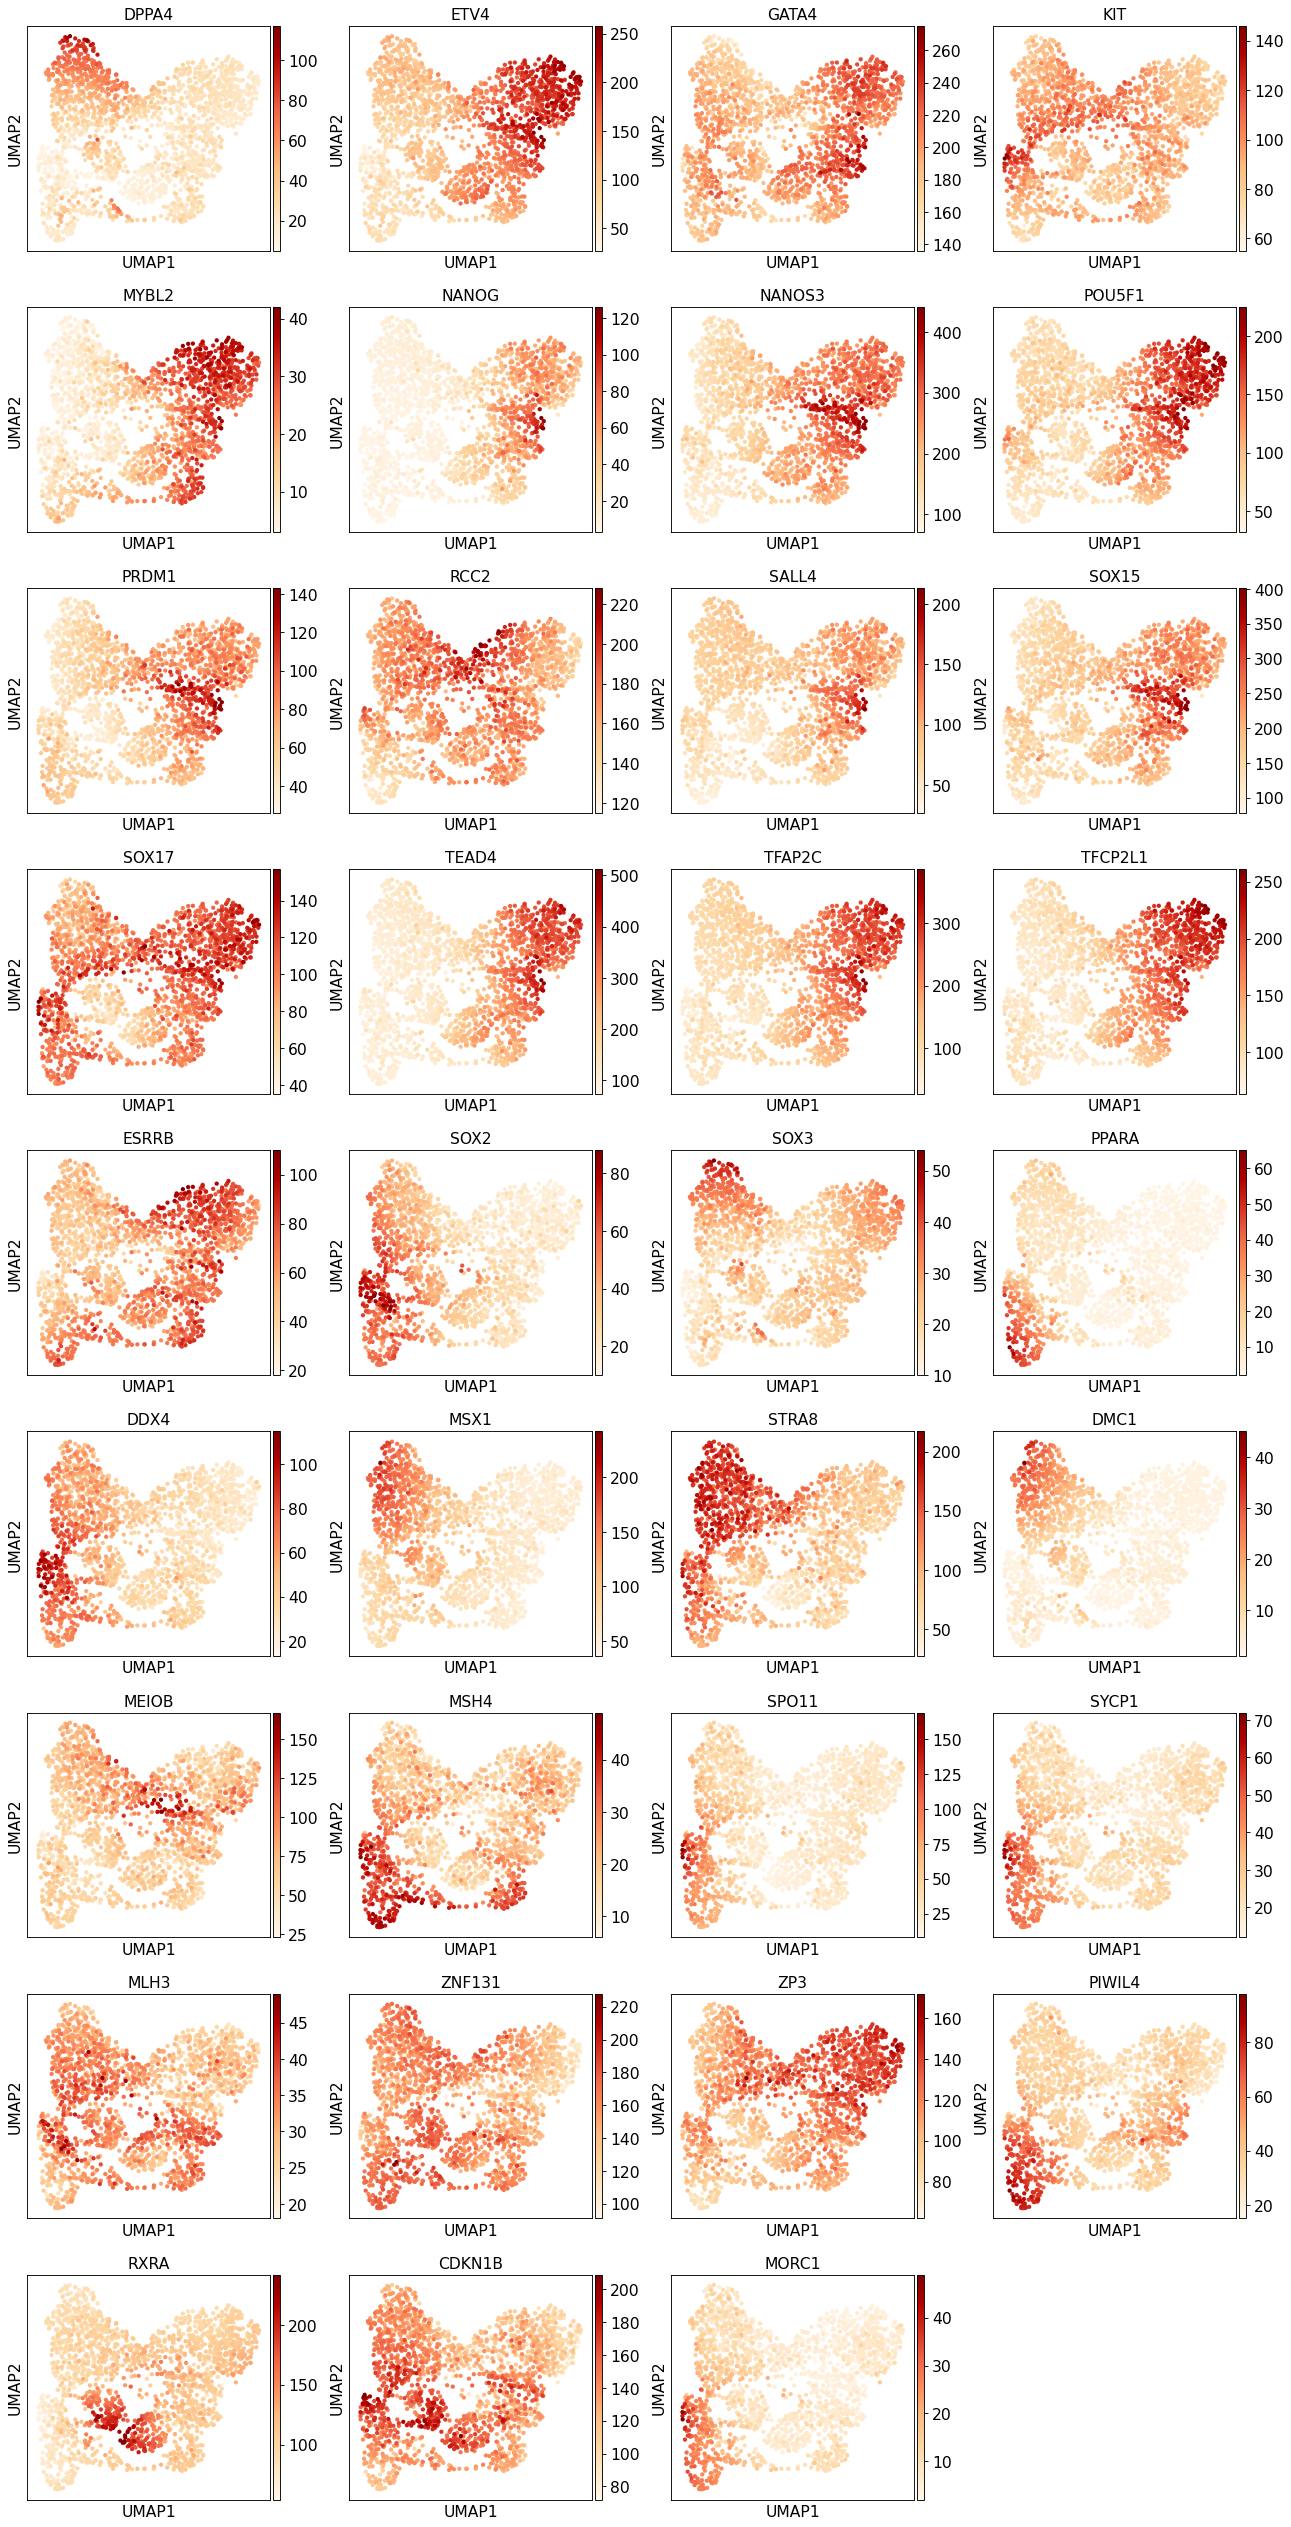

In [18]:
sc.pl.umap(gene_data, color = present, color_map = 'OrRd', save = 'markers')

In [19]:
predicted_probabilities.columns = ['PGC_mitotic', 'PGC', 'pre-spermatogonia', 'GC_mitotic', 
       'oogonia_STRA8', 'oogonia_meiosis','oocyte', 'max']

In [20]:
for pred in predicted_probabilities.columns: 
    print(pred)
    gene_data.obs[pred] = predicted_probabilities[pred]

PGC_mitotic
PGC
pre-spermatogonia
GC_mitotic
oogonia_STRA8
oogonia_meiosis
oocyte
max


In [14]:
gonads_colors = ['#c466b0',  '#60bddb', '#e64e74','#edb7b7', '#779eed', '#7b9e99',  '#ebd3c3' , '#d96884','#70ccbe', 
               '#7b9e99', '#edb7b7', '#91bd80', '#d9a5c3','#cc8fdb', '#71a2c7','#bdb380',  '#d4db81', '#ebd3c3',  '#dba781',  '#60bddb', 
               '#e08b8b', '#d9abb7','#aad3f2', '#e64e74',  ]

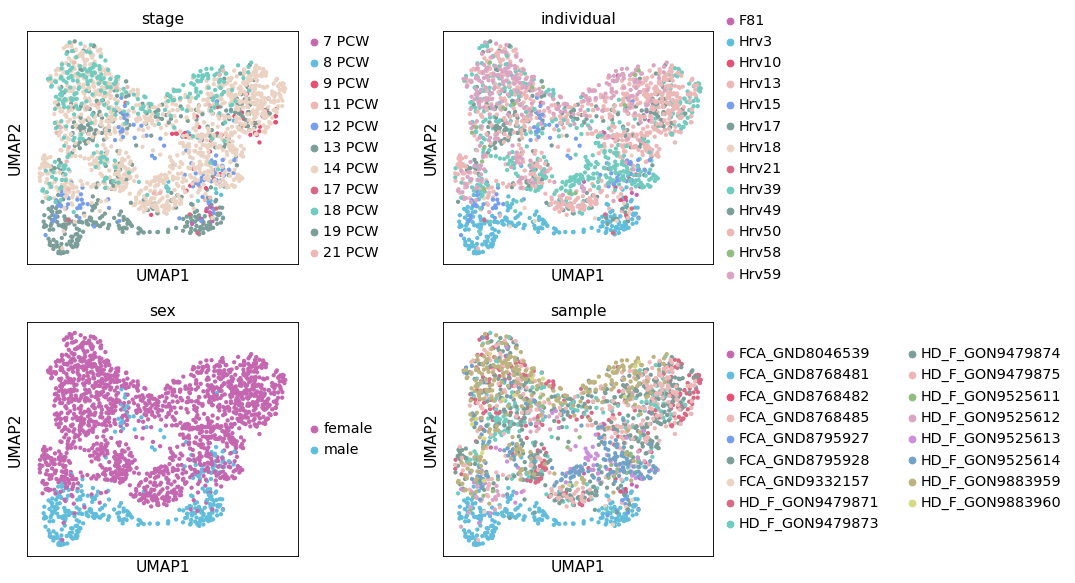

In [22]:
sc.pl.umap(gene_data, color = ['stage', 'individual', 'sex', 'sample'], ncols = 2, wspace = 0.4, 
           palette = gonads_colors, save = "noharmony.pdf")

In [23]:
gene_data.obs.columns

Index(['cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage',
       'individual', 'PGC_mitotic', 'PGC', 'pre-spermatogonia', 'GC_mitotic',
       'oogonia_STRA8', 'oogonia_meiosis', 'oocyte', 'max'],
      dtype='object')

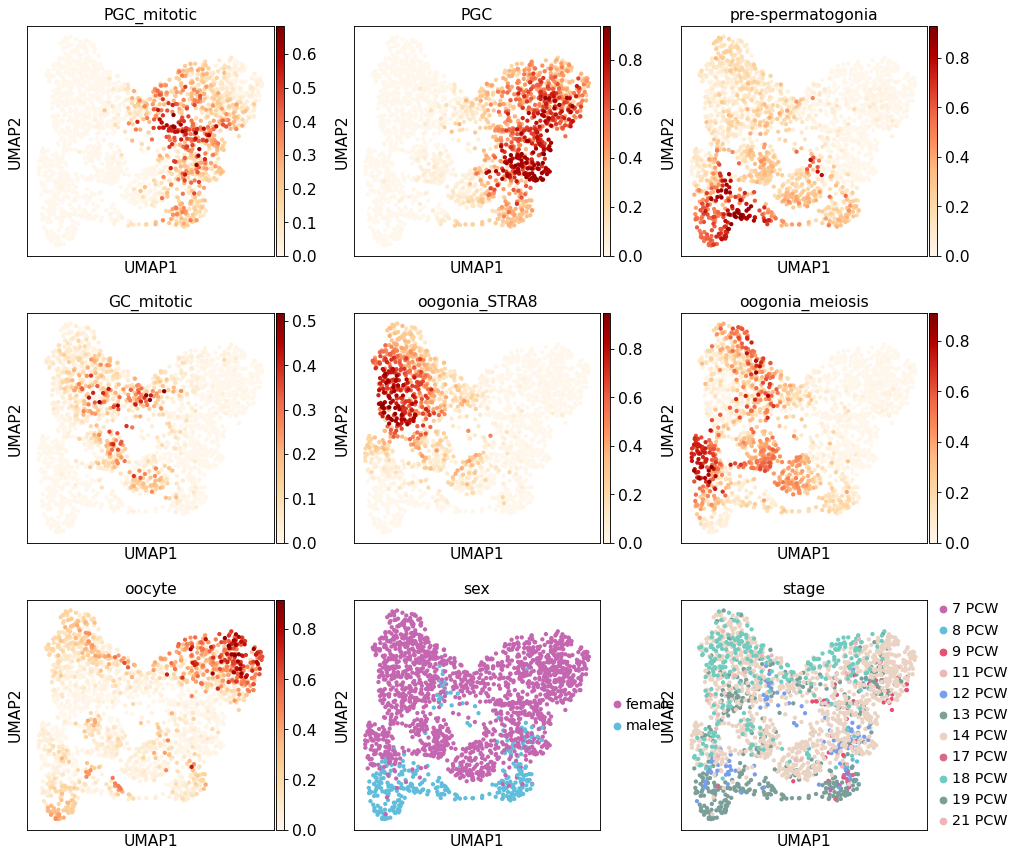

In [24]:
sc.pl.umap(gene_data, color = ['PGC_mitotic', 'PGC', 'pre-spermatogonia', 'GC_mitotic', 
       'oogonia_STRA8', 'oogonia_meiosis','oocyte', 'sex', 'stage'], ncols = 3, color_map = 'OrRd', save = "_probs_noharmony.pdf")

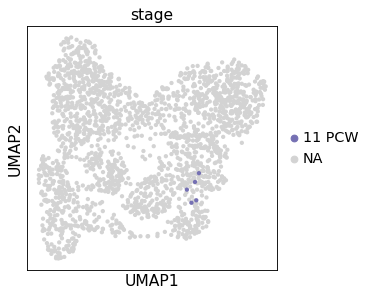

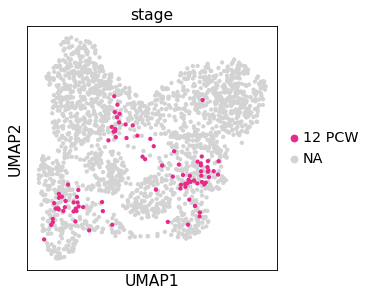

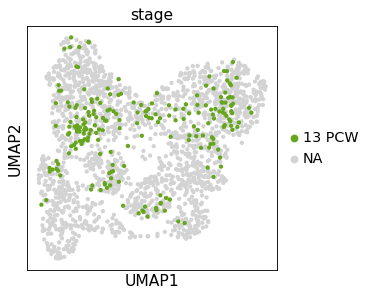

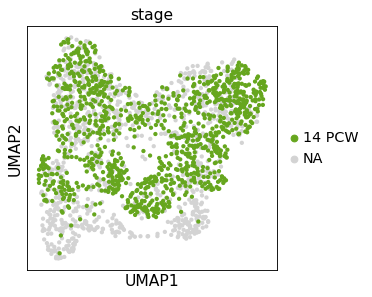

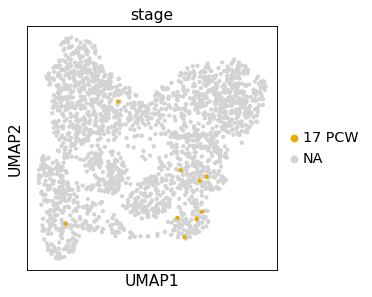

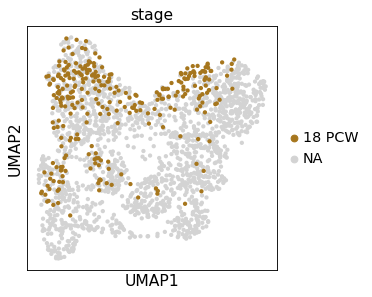

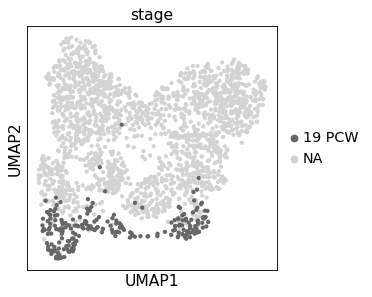

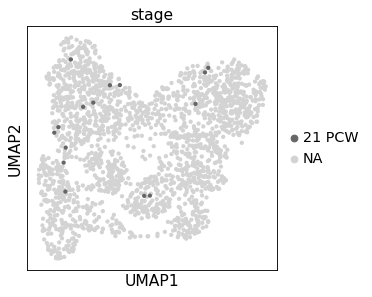

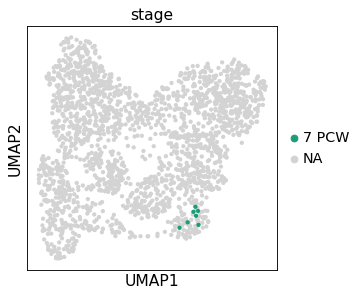

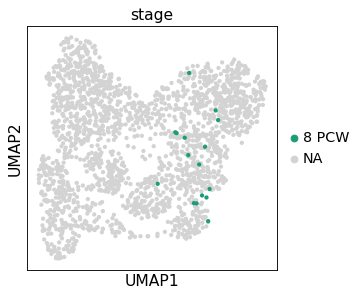

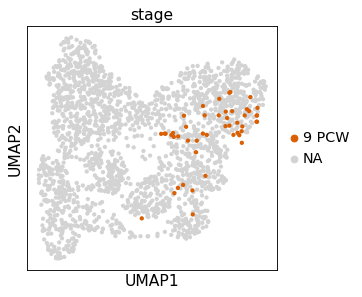

In [25]:
for i in np.unique(gene_data.obs['stage']):
    sc.pl.umap(gene_data, color = 'stage', groups = i, palette = 'Dark2')

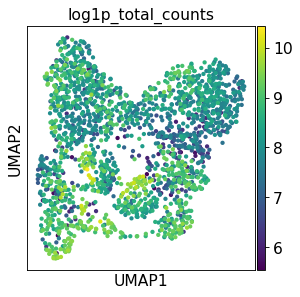

In [26]:
sc.pl.umap(gene_data, color = ['log1p_total_counts'])

#### Look at average gene activity scores to identify cycling population

This was suggested by Luz 

In [27]:
gene_data.X

array([[27., 20., 20., ..., 50., 27.,  4.],
       [39., 26., 26., ..., 48., 25.,  6.],
       [60., 47., 47., ..., 55., 23.,  3.],
       ...,
       [73., 58., 58., ..., 80., 31.,  3.],
       [39., 20., 20., ..., 78., 41.,  6.],
       [40., 21., 21., ..., 81., 42.,  6.]], dtype=float32)

In [28]:
mean_by_cell = gene_data.X.mean(axis=1)
mean_by_cell

array([81.3906 , 80.40306, 78.33505, ..., 78.26093, 77.02881, 76.09103],
      dtype=float32)

In [29]:
means = pd.DataFrame(mean_by_cell, columns=['mean_gene_activity'], index=gene_data.obs_names)
means.head()

mean_gene_activity
01-ACAGAAAAGAGGAATG-1           81.390602
01-ACTTTCAAGGGCTCTC-1           80.403061
01-AGCCAGCAGGTGTCGA-1           78.335052
01-CAGCTAATCTGGCGCA-1           76.407982
01-GCACCTTGTTACGGAG-1           77.865486

In [30]:
gene_data.obs['mean_gene_activity'] = means

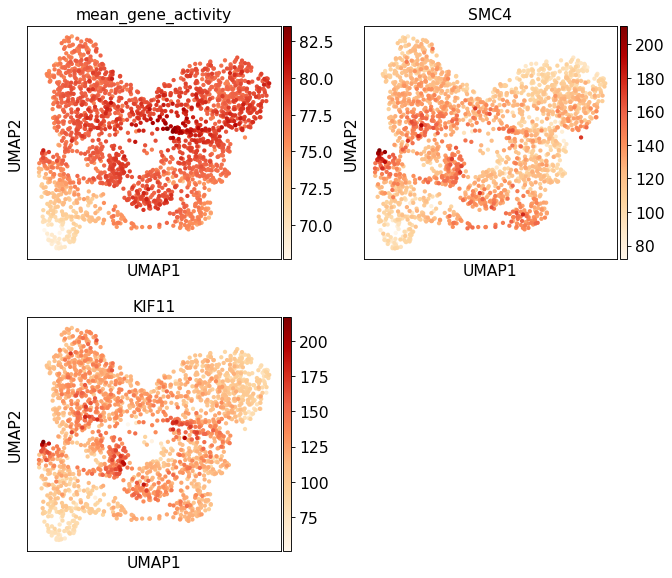

In [32]:
sc.pl.umap(gene_data, color = ['mean_gene_activity', 'SMC4', 'KIF11'], ncols = 2, color_map = "OrRd")

In [33]:
cell_cycle_genes = [x.strip() for x in open(file='/nfs/users/nfs_v/vl6/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in gene_data.var_names]
print(s_genes)
g2m_genes = [x for x in g2m_genes if x in gene_data.var_names]
print(g2m_genes)

['MCM5', 'MCM2', 'DTL', 'UHRF1', 'HELLS', 'RFC2', 'WDR76', 'UBR7', 'POLD3', 'MSH2', 'EXO1', 'TIPIN', 'DSCC1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1']
['NUSAP1', 'TPX2', 'CENPF', 'TACC3', 'SMC4', 'CKAP2', 'AURKB', 'KIF11', 'ANP32E', 'GTSE1', 'HJURP', 'HN1', 'RANGAP1', 'CDCA2', 'PSRC1', 'CKAP5', 'CTCF', 'G2E3', 'CBX5', 'CENPA']


In [34]:
#sc.pl.umap(gene_data, color = s_genes, color_map = "OrRd")

In [35]:
#sc.pl.umap(gene_data, color = g2m_genes, color_map = "OrRd")

In [36]:
gene_data.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

**Save the predicted annotations to the peaks anndata object for ATAC**

In [47]:
adata = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")
adata

AnnData object with n_obs × n_vars = 1998 × 86770
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0_75', 'PGC_mitotic', 'PGC', 'pre-spermatogonia', 'GC_mitotic', 'oogonia_STRA8', 'oogonia_meiosis', 'oocyte', 'max'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_11', 'X_cistopic_14', 'X_cistopic_18', 'X_cistopic_20', 'X_umap'
    varm: 'peak2gene'
    layers: 'binary_raw', 'cistopic_p

In [48]:
for pred in predicted_probabilities.columns: 
    print(pred)
    adata.obs[pred] = predicted_probabilities[pred]

PGC_mitotic
PGC
pre-spermatogonia
GC_mitotic
oogonia_STRA8
oogonia_meiosis
oocyte
max


In [49]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

#### Visualize position in the manifold of dual ATAC samples

#### Clustering

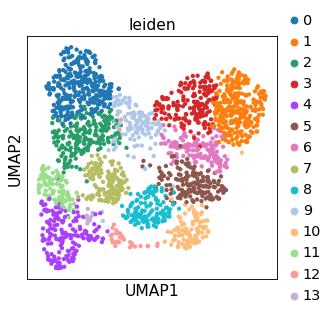

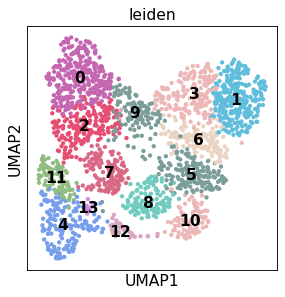

In [54]:
sc.tl.leiden(adata, resolution=1, random_state = 1234)
sc.pl.umap(adata, color='leiden',save='_clustering.pdf')
sc.pl.umap(adata, color='leiden',legend_loc='on data',save='_clustering_clusnumbers.pdf', palette = gonads_colors)

In [108]:
clusters = {'0' : 'oogonia_STRA8', '1' : 'PGC', '2' : 'oogonia_STRA8', '3' : 'PGC', '6' : 'PGC', '5' : 'PGC', '10' : 'PGC',
           '8' : 'PGC', '7' : 'GC_mitotic', '12' : 'pre-spermatogonia', '4' : 'pre-spermatogonia', '11' : 'oogonia_meiosis', '13' : 
           'pre-spermatogonia', '9' : 'GC_mitotic'}
adata.obs['clusters'] = adata.obs['leiden'].map(clusters)
adata.obs['clusters'].value_counts(dropna = False)

PGC                  966
oogonia_STRA8        493
GC_mitotic           248
pre-spermatogonia    205
oogonia_meiosis       86
Name: clusters, dtype: int64

... storing 'clusters' as categorical


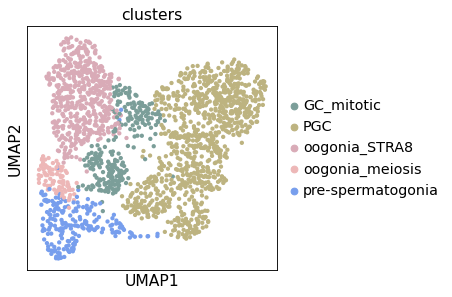

In [109]:
sc.pl.umap(adata, color = 'clusters', palette = gonads_colors)

In [110]:
adata.obs['clusters'] = adata.obs['clusters'].astype(str)
adata.obs['clusters'] = adata.obs['clusters'].astype("category")
adata.obs['clusters'] = adata.obs['clusters'].cat.reorder_categories(['PGC', 'GC_mitotic',
                                'oogonia_STRA8', 
                            'oogonia_meiosis', 'pre-spermatogonia'])

In [111]:
gonads_colors = ['#7b9e99', '#bdb380', '#d9abb7', '#edb7b7', '#779eed']

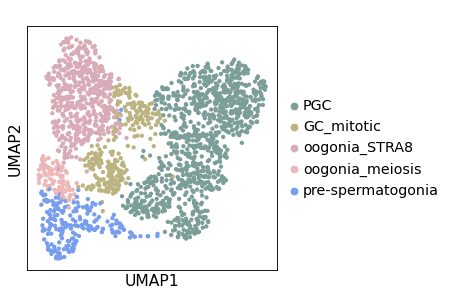

In [113]:
sc.pl.umap(adata, color = 'clusters', title = " ", palette = gonads_colors, save = "clusters")

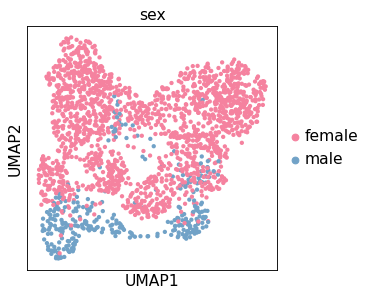

In [10]:
sex_colors = ['#f5829f', '#71a2c7']
sc.pl.umap(adata, color='sex',legend_fontsize = 'medium', legend_fontweight = 'medium',
           save='_germCells_sex.pdf', palette = sex_colors)

In [11]:
# Transform the stage variable in numeric to plot the PCW as a gradient
pcws_dict = {'11 PCW' : 11, '12 PCW' : 12, '13 PCW' : 13, '14 PCW' : 14, '15 PCW' : 15, '17 PCW' : 17,
       '18 PCW' : 18, '19 PCW' : 19, '21 PCW' : 21, '7 PCW' : 7, '8 PCW' : 8, '9 PCW' : 9}
adata.obs['stage_numeric'] = adata.obs['stage'].map(pcws_dict)
adata.obs['stage_numeric'].value_counts(dropna = False)

14    1099
18     290
19     221
13     214
12      85
9       48
8       14
21      14
17       9
7        4
Name: stage_numeric, dtype: int64

In [12]:
adata.obs['stage_numeric'] = adata.obs['stage_numeric'].astype(float)

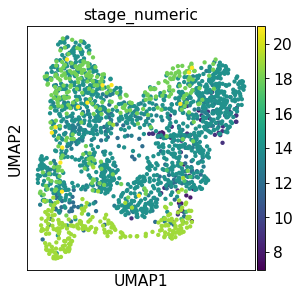

In [13]:
sc.pl.umap(adata, color='stage_numeric',legend_fontsize = 'medium', 
           legend_fontweight = 'medium', color_map = 'viridis',
           save='_germCells_stage.pdf')

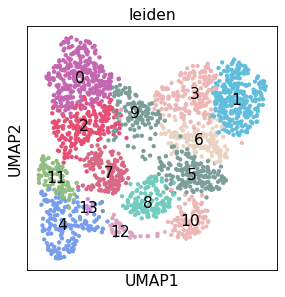

In [15]:
sc.pl.umap(adata, color='leiden',legend_loc='on data',save='_clustering_clusnumbers.pdf', 
           palette = gonads_colors, legend_fontsize = 'medium', 
           legend_fontweight = 'medium')

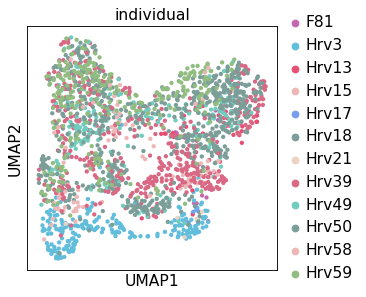

In [16]:
sc.pl.umap(adata, color='individual',legend_fontsize = 'medium', legend_fontweight = 'medium',
           save='_germCells_individual.pdf', palette = gonads_colors)

In [9]:
adata = sc.read(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")
adata

AnnData object with n_obs × n_vars = 1998 × 86770
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0_75', 'PGC_mitotic', 'PGC', 'pre-spermatogonia', 'GC_mitotic', 'oogonia_STRA8', 'oogonia_meiosis', 'oocyte', 'max', 'leiden', 'clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_11', 'X_cistopic_14', 'X_cistopic_18', 'X_cistopic_20', 

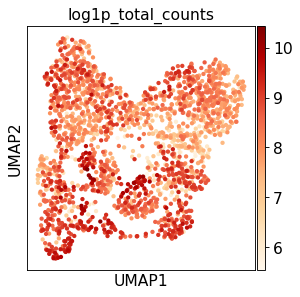

In [104]:
sc.pl.umap(adata, color = ['log1p_total_counts'], color_map = 'OrRd', save = '_log1p_total_counts')

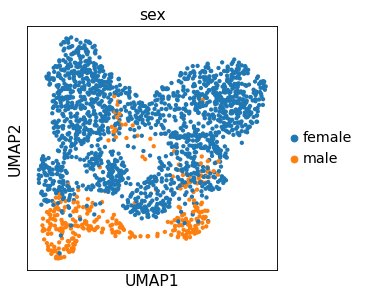

In [103]:
sc.pl.umap(adata, color = ['sex'], save = '_sex')

In [12]:
## Add sex info on PGCs and GCs
adata.obs['clusters_sex'] = adata.obs['clusters'].astype(str) + '_' + adata.obs['sex'].astype(str)
adata.obs['clusters_sex_final'] = np.where(adata.obs['clusters'].isin(['PGC', 'GC_mitotic']), 
                                     adata.obs['clusters_sex'], adata.obs['clusters'])
adata.obs['clusters_sex_final'].value_counts(dropna = False)

PGC_female           684
Oogonia_STRA8        363
GC_mitotic_female    228
Gonocyte             141
GC_XY                101
Oogonia_meiotic       79
PGC_male              42
GC_mitotic_male       17
Name: clusters_sex_final, dtype: int64

In [91]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

In [81]:
ordered_probs = ['PGC_mitotic',
       'PGC', 'pre-spermatogonia', 'GC_mitotic', 'oogonia_STRA8',
       'oogonia_meiosis', 'oocyte']

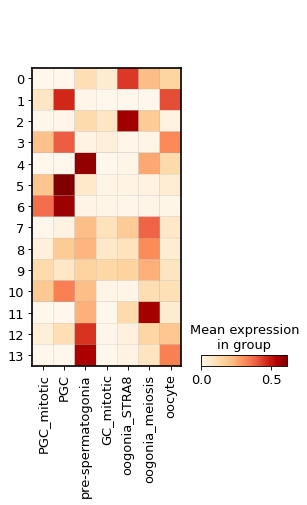

In [82]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'leiden', cmap = 'OrRd',
                  save = '_matrixplot.pdf')

In [84]:
ordered_probs = ['PGC', 'PGC_mitotic',
        'GC_mitotic', 'oogonia_STRA8',
       'oogonia_meiosis', 'pre-spermatogonia', 'oocyte']

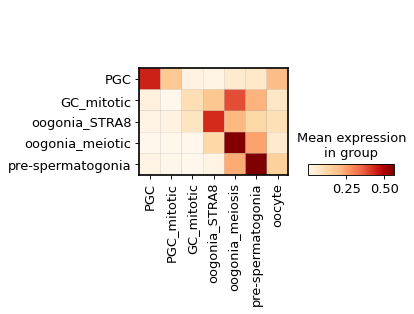

In [85]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'clusters', cmap = 'OrRd',
                  save = '_matrixplot.pdf')

### Import annotations from dualRNA Luz 

In [17]:
annotations_dualRNA_female = pd.read_csv("/nfs/team292/lg18/with_valentina/gonadsV1_freezed/dual_snRNAsnATAC_female_Hrv39_germcells.csv", index_col = 0)
annotations_dualRNA_male = pd.read_csv("/nfs/team292/lg18/with_valentina/gonadsV1_freezed/dual_snRNAsnATAC_male_Hrv15_germcells_predictions.csv", index_col = 0)
annotations_dualRNA = annotations_dualRNA_female.append(annotations_dualRNA_male)
annotations_dualRNA.head()

n_genes           sample  donor  \
HD_F_GON9525421_AAACCGAAGCCTGGTA     6198  HD_F_GON9525421  Hrv39   
HD_F_GON9525421_ACGAGTAAGTTTGGGT     4012  HD_F_GON9525421  Hrv39   
HD_F_GON9525421_AGCGATTTCCCGCCTA     5462  HD_F_GON9525421  Hrv39   
HD_F_GON9525421_AGGTTAACAATAGCAA     8304  HD_F_GON9525421  Hrv39   
HD_F_GON9525421_AGGTTAGAGTAAGTGG     6594  HD_F_GON9525421  Hrv39   

                                          Library_ATAC  Library_RNA      iRods_path  \
HD_F_GON9525421_AAACCGAAGCCTGGTA  HD_F_GON9525613        HD_F_GON9525421        ...   
HD_F_GON9525421_ACGAGTAAGTTTGGGT  HD_F_GON9525613        HD_F_GON9525421        ...   
HD_F_GON9525421_AGCGATTTCCCGCCTA  HD_F_GON9525613        HD_F_GON9525421        ...   
HD_F_GON9525421_AGGTTAACAATAGCAA  HD_F_GON9525613        HD_F_GON9525421        ...   
HD_F_GON9525421_AGGTTAGAGTAAGTGG  HD_F_GON9525613        HD_F_GON9525421        ...   

                                  percent_mito  n_counts batch  \
HD_F_GON9525421_AAACCGAAGCCTGGTA      0.001147   12617.0     2   
HD_F_GON9525421_ACGAGTAAGTTTGGGT      0.002767    6792.0     2   
HD_F_GON9525421_AGCGATTTCCCGCCTA      0.000000   10969.0     2   
HD_F_GON9525421_AGGTTAACAATAGCAA      0.000581   24267.0     2   
HD_F_GON9525421_AGGTTAGAGTAAGTGG      0.002235   11271.0     2   

                                  scrublet_score  scrublet_cluster_score  \
HD_F_GON9525421_AAACCGAAGCCTGGTA        0.142857                0.152941   
HD_F_GON9525421_ACGAGTAAGTTTGGGT        0.205882                0.233613   
HD_F_GON9525421_AGCGATTTCCCGCCTA        0.176471                0.152941   
HD_F_GON9525421_AGGTTAACAATAGCAA        0.205882                0.233613   
HD_F_GON9525421_AGGTTAGAGTAAGTGG        0.223529                0.152941   

                                    zscore   bh_pval  bonf_pval  is_doublet  \
HD_F_GON9525421_AAACCGAAGCCTGGTA  0.202347  0.933846        1.0       False   
HD_F_GON9525421_ACGAGTAAGTTTGGGT  1.821125  0.480450        1.0       False   
HD_F_GON9525421_AGCGATTTCCCGCCTA  0.202347  0.933846        1.0       False   
HD_F_GON9525421_AGGTTAACAATAGCAA  1.821125  0.480450        1.0       False   
HD_F_GON9525421_AGGTTAGAGTAAGTGG  0.202347  0.933846        1.0       False   

                                  leiden    clusters  leiden_R predictions  \
HD_F_GON9525421_AAACCGAAGCCTGGTA       0         PGC       4.0         NaN   
HD_F_GON9525421_ACGAGTAAGTTTGGGT       2         PGC       4.0         NaN   
HD_F_GON9525421_AGCGATTTCCCGCCTA       2         PGC       4.0         NaN   
HD_F_GON9525421_AGGTTAACAATAGCAA       3  GC_mitotic       4.0         NaN   
HD_F_GON9525421_AGGTTAGAGTAAGTGG       2         PGC       4.0         NaN   

                                  probabilities  
HD_F_GON9525421_AAACCGAAGCCTGGTA            NaN  
HD_F_GON9525421_ACGAGTAAGTTTGGGT            NaN  
HD_F_GON9525421_AGCGATTTCCCGCCTA            NaN  
HD_F_GON9525421_AGGTTAACAATAGCAA            NaN  
HD_F_GON9525421_AGGTTAGAGTAAGTGG            NaN

In [18]:
annotations_dualRNA_female['clusters'].value_counts(dropna = False)

PGC                104
oogonia_STRA8       45
GC_mitotic          30
oogonia_meiotic     20
Name: clusters, dtype: int64

In [20]:
adata.obs[['sample', 'code']].value_counts()

sample           code
HD_F_GON9479874  04      379
HD_F_GON9883959  06      290
HD_F_GON9479875  05      264
HD_F_GON9479871  02      244
FCA_GND8768481   08      221
HD_F_GON9479873  03      214
HD_F_GON9525614  17      158
HD_F_GON9525613  16       54
FCA_GND8768485   10       48
HD_F_GON9525612  15       45
HD_F_GON9525611  14       26
FCA_GND8046539   01       14
FCA_GND8795928   12       14
HD_F_GON9883960  07       14
FCA_GND9332157   13        9
FCA_GND8795927   11        4
dtype: int64

 * ATAC 13 --> RNA 21, code = 09
 * ATAC 14 --> RNA 22, code = 10

In [21]:
annotations_dualRNA_female.index = [i.replace("HD_F_GON9525421_", "16-") for i in annotations_dualRNA_female.index]
annotations_dualRNA_female.index = [i.replace("HD_F_GON9525422_", "17-") for i in annotations_dualRNA_female.index]
annotations_dualRNA.index = [i.replace("HD_F_GON9525419_", "14-") for i in annotations_dualRNA.index]
annotations_dualRNA.index = [i.replace("HD_F_GON9525420_", "15-") for i in annotations_dualRNA.index]

In [22]:
annotations_dualRNA_female.index = [i + "-1" for i in annotations_dualRNA_female.index]

In [23]:
dualRNA_mapping = annotations_dualRNA_female['clusters'].to_dict()

In [24]:
adata.obs['dualRNA_label'] = adata.obs_names.map(dualRNA_mapping)

In [25]:
adata.obs['dualRNA_label'].value_counts(dropna = False)

NaN                1857
PGC                  81
oogonia_STRA8        41
oogonia_meiotic      14
GC_mitotic            5
Name: dualRNA_label, dtype: int64

In [26]:
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].fillna("scATAC-seq only")

In [27]:
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].astype("category")
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].cat.reorder_categories(['PGC', 'GC_mitotic', 
                                                            'oogonia_STRA8', 'oogonia_meiotic', 
                                                                               'scATAC-seq only'])

In [28]:
gonads_colors = ['#7b9e99', '#bdb380', '#d9abb7', '#edb7b7', 'aliceblue']

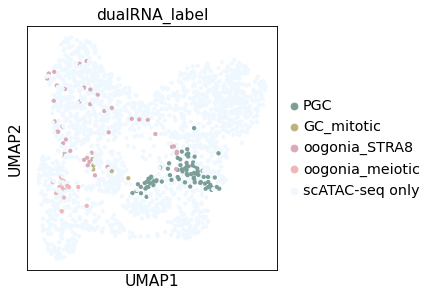

In [31]:
sc.pl.umap(adata, color = "dualRNA_label", save = "_dual.pdf", palette = gonads_colors)

#### End of notebook